In [6]:
import os
import numpy as np
import tifffile
from tqdm import tqdm


def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.

    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted(
        [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if (f.endswith(".tiff") or f.endswith(".tif"))
        ]
    )

    tiff_sequence = tifffile.TiffSequence(tiff_files)

    # Get the total number of TIFF files
    total_files = len(tiff_files)

    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)

            # Update progress
            pbar.update(1)

    return np.array(volume)

In [7]:
def write_sequence(folder_path, name, volume):
    """
    Save a 3D volume as a sequence of TIFF files in a folder.

    Args:
    folder_path (str): Path to the folder where TIFF files will be saved.
    name (str): Name of the TIFF files.
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.
    """

    folder_path = folder_path / name

    # Create the folder if it doesn't exist
    Path(folder_path).mkdir(parents=True, exist_ok=True)

    # Save each slice as a TIFF file with progress bar
    with tqdm(total=volume.shape[0], desc="Saving") as pbar:
        for i in range(volume.shape[0]):
            tifffile.imwrite(f"{folder_path}/{name}_{i:04d}.tif", volume[i])
            pbar.update(1)

    print("Saving complete.")

In [8]:
from pathlib import Path

folder1 = Path(r"E:\temporal\volumenes\2+3+4+5\probando\x")
folder2 = Path(r"E:\temporal\volumenes\2+3+4+5\probando\y")
folder3 = Path(r"E:\temporal\volumenes\2+3+4+5\probando\botac")
folder4 = Path(r"E:\temporal\volumenes\2+3+4+5\probando\topac")

# bot = read_sequence(folder1)
# top = read_sequence(folder2)

bot_full = read_sequence(folder3)
top_full = read_sequence(folder4)

roi2 = [1416, 1776, 66, 177]
# y0,y1,x0,x1 in fiji
roi = [417, 558, 24, 99]

bot = bot_full[:, roi[0] : roi[1], roi[2] : roi[3]]
top = top_full[:, roi[0] : roi[1], roi[2] : roi[3]]

bot2 = bot_full[:, roi2[0] : roi2[1], roi2[2] : roi2[3]]
top2 = top_full[:, roi2[0] : roi2[1], roi2[2] : roi2[3]]

# flip slices order in top volume
# top = top[::-1]

# print the shapes
print(bot.shape)
print(top.shape)
print(bot_full.shape)
print(top_full.shape)

Progress: 100%|██████████| 1024/1024 [00:01<00:00, 520.30it/s]


(1003, 141, 75)
(1024, 141, 75)
(1003, 1900, 300)
(1024, 1900, 300)


In [9]:
from skimage.filters import threshold_otsu
from skimage.measure import regionprops
from skimage.measure import label
from scipy.ndimage import binary_fill_holes


def onlypores(volume, top_threshold=235):
    vol = volume.copy()

    vol[vol > top_threshold] = 0

    # Otsu's thresholding
    thresh = threshold_otsu(vol)
    binary = vol > thresh

    binary = binary.astype(np.uint8)

    # label
    labeled = label(binary)

    # regionprops
    props = regionprops(labeled)

    # Find the largest connected component
    largest_component = max(props, key=lambda region: region.area)
    # Create a mask to keep only the largest component
    mask = np.zeros_like(labeled)
    mask[labeled == largest_component.label] = 1
    mask = binary_fill_holes(mask).astype(int)

    return mask

In [11]:
mask_bot = onlypores(bot)
mask_top = onlypores(top)
mask_bot_full = onlypores(bot_full)

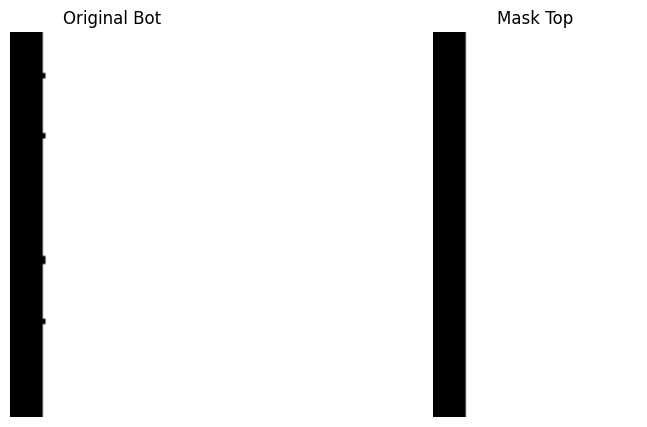

In [12]:
# plot a slice from the mask and the original volume
import matplotlib.pyplot as plt

slice_index = 133
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask_bot[slice_index], cmap="gray")
plt.title("Original Bot")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask_top[slice_index], cmap="gray")
plt.title("Mask Top")
plt.axis("off")
plt.show()

In [13]:
def find_candidates_slice(
    frameid, length, resolution, vol1shape, vol2shape, range_slices=200, show=False
):
    """
    Find the candidates for a given frameid, length and resolution.

    Args:
    frameid (int): Frame id of the first volume.
    length (int): Length of the sample scanned in two volumes in millimeters.
    resolution (int): Resolution of the scan.
    vol1shape (int): Number of slices in the first volume.
    vol2shape (int): Number of slices in the second volume.

    Returns:
    list: List of candidates to be the same slice in the second volume as frameid in the first.
    """

    # Calculate the number of slices needed to cover the length of the sample
    n_slices = int(length / resolution)

    # Calulate the remaining slices needed to cover the length of the sample
    remaining = n_slices - frameid

    # Calculate where should the first slice of he second volume be to fit the length of the sample
    start_vol2 = vol2shape - remaining

    # print all
    if show:
        print(
            f"frameid: {frameid}, n_slices: {n_slices}, remaining: {remaining}, start_vol2: {start_vol2}"
        )

    # define range
    start = np.clip(start_vol2 - range_slices // 2, a_min=0, a_max=None)
    end = np.clip(start_vol2 + range_slices // 2, a_min=None, a_max=vol2shape)

    # Create a list of candidates, all numbers in a range of 200 being start_vol2 the center
    candidates = [i for i in range(start, end)]

    # Create tuples of one candidate and the frameid
    return np.array([(frameid, candidate) for candidate in candidates])

In [14]:
# create a function that given two volumes, i and j as coincident slices, return a concatenated volume
def concatenate_volumes(vol1, vol2, i, j):
    """
    Concatenate two volumes.

    Args:
    vol1 (numpy.ndarray): First volume.
    vol2 (numpy.ndarray): Second volume.
    i (int): Slice id of the first volume.
    j (int): Slice id of the second volume.

    Returns:
    numpy.ndarray: Concatenated volume.
    """
    # concatenate the two volumes
    concatenated = np.concatenate((vol1[:i], vol2[j:]), axis=0)

    # return the concatenated volume
    return concatenated

In [15]:
resolution = 21.8 / 1000

slicesa = len(bot)

slicesb = len(top)

length = 165

slices_to_analyze = 10

lengtha = resolution * slicesa

lengthb = resolution * slicesb

end_top = length - lengtha

print("overlapping region is: ", end_top, "-", lengtha)

slice1 = int(end_top / resolution)

slice2 = int((lengtha - end_top) / resolution)

print("overlapping slice volume1 from:", slice1, "to", slicesa)
print("overlapping slice volume2 from:", 0, "-", slice2)

overlapping region is:  143.1346 - 21.8654
overlapping slice volume1 from: 6565 to 1003
overlapping slice volume2 from: 0 - -5562


In [16]:
import matplotlib.pyplot as plt

# Global variable to store the metric values at each iteration
metric_values = []


def start_plot():
    global metric_values
    metric_values = []


def end_plot():
    plt.figure()
    plt.plot(metric_values, "r")
    plt.title("Metric Value Evolution")
    plt.xlabel("Iteration Number")
    plt.ylabel("Metric Value")
    plt.show()


def update_multires_iterations():
    print("Performing registration at new resolution...")


def plot_values(registration_method):
    global metric_values
    metric_values.append(registration_method.GetMetricValue())

In [17]:
import SimpleITK as sitk

# Load the fixed and moving images
fixed_image = sitk.GetImageFromArray(bot)
moving_image = sitk.GetImageFromArray(top)
fixed_image_full = sitk.GetImageFromArray(bot_full)
moving_image_full = sitk.GetImageFromArray(top_full)
fixed_image2 = sitk.GetImageFromArray(bot2)
moving_image2 = sitk.GetImageFromArray(top2)
fixed_mask_image = sitk.GetImageFromArray(mask_bot * 255)
moving_mask_image = sitk.GetImageFromArray(mask_top * 255)
fixed_mask_image_full = sitk.GetImageFromArray(mask_bot_full * 255)

In [18]:
# Initial alignment of the two volumes
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.AffineTransform(3),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

In [19]:
# Set up the registration framework
registration_method = sitk.ImageRegistrationMethod()

# mask settings
registration_method.SetMetricFixedMask(fixed_mask_image)
registration_method.SetMetricMovingMask(moving_mask_image)

# Similarity metric settings
# registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricAsMeanSquares()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(1)

# Interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings
registration_method.SetOptimizerAsRegularStepGradientDescent(
    learningRate=2.0,
    minStep=1e-4,
    numberOfIterations=100,
    relaxationFactor=0.5,
    gradientMagnitudeTolerance=1e-8,
    estimateLearningRate=registration_method.EachIteration,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
)
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: plot_values(registration_method)
)

0

Performing registration at new resolution...
Performing registration at new resolution...
Performing registration at new resolution...


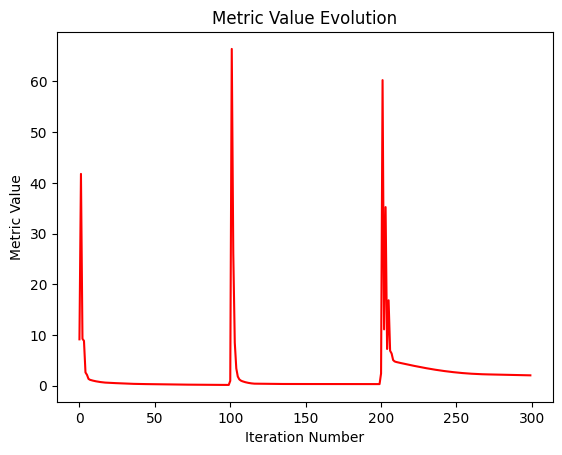

In [20]:
# Run the registration
final_transform = registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)

In [21]:
# Now, apply this transform to the original top volume
resampler = sitk.ResampleImageFilter()
resampler.SetTransform(final_transform)

# Set the properties of the resampler to match the original top volume
resampler.SetOutputSpacing(fixed_image.GetSpacing())
resampler.SetSize(fixed_image.GetSize())
resampler.SetOutputDirection(fixed_image.GetDirection())
resampler.SetOutputOrigin(fixed_image.GetOrigin())
resampler.SetDefaultPixelValue(fixed_image.GetPixelIDValue())

# Apply the transformation
resampled_moving_image = resampler.Execute(moving_image)

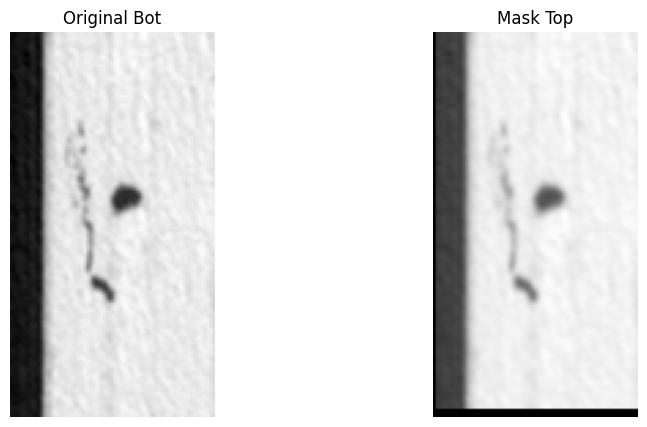

In [22]:
# plot a slice from the mask and the original volume
import matplotlib.pyplot as plt

slice_index = 54
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sitk.GetArrayFromImage(fixed_image)[slice_index], cmap="gray")
plt.title("Original Bot")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(sitk.GetArrayFromImage(resampled_moving_image)[slice_index], cmap="gray")
plt.title("Mask Top")
plt.axis("off")
plt.show()

In [23]:
# Now, apply this transform to the original top volume
resampler = sitk.ResampleImageFilter()
resampler.SetTransform(final_transform)

# Set the properties of the resampler to match the original top volume
resampler.SetOutputSpacing(fixed_image2.GetSpacing())
resampler.SetSize(fixed_image2.GetSize())
resampler.SetOutputDirection(fixed_image2.GetDirection())
resampler.SetOutputOrigin(fixed_image2.GetOrigin())
resampler.SetDefaultPixelValue(fixed_image2.GetPixelIDValue())

# Apply the transformation
resampled_moving_image2 = resampler.Execute(moving_image2)

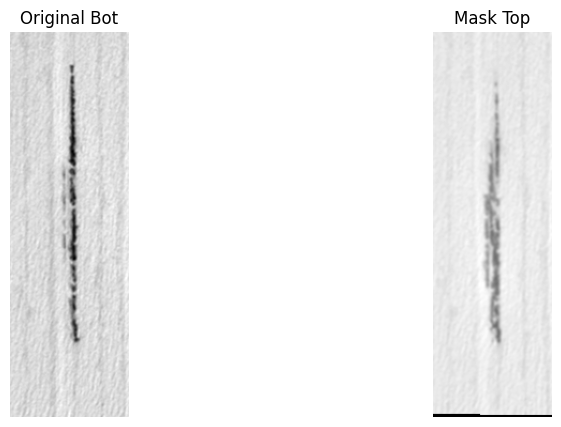

In [24]:
# plot a slice from the mask and the original volume
import matplotlib.pyplot as plt

slice_index = 124
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sitk.GetArrayFromImage(fixed_image2)[slice_index], cmap="gray")
plt.title("Original Bot")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(sitk.GetArrayFromImage(resampled_moving_image2)[slice_index], cmap="gray")
plt.title("Mask Top")
plt.axis("off")
plt.show()

In [25]:
# Now, apply this transform to the original top volume
resampler = sitk.ResampleImageFilter()
resampler.SetTransform(final_transform)

# Set the properties of the resampler to match the original top volume
resampler.SetOutputSpacing(fixed_image_full.GetSpacing())
resampler.SetSize(fixed_image_full.GetSize())
resampler.SetOutputDirection(fixed_image_full.GetDirection())
resampler.SetOutputOrigin(fixed_image_full.GetOrigin())
resampler.SetDefaultPixelValue(fixed_image_full.GetPixelIDValue())

# Apply the transformation
registered_volume_top = resampler.Execute(moving_image_full)

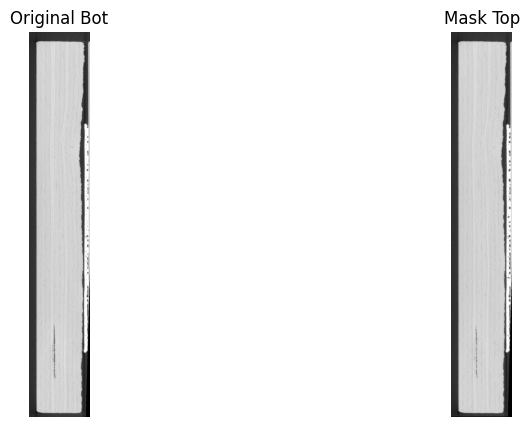

In [26]:
# plot a slice from the mask and the original volume
import matplotlib.pyplot as plt

slice_index = 124
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sitk.GetArrayFromImage(fixed_image_full)[slice_index], cmap="gray")
plt.title("Original Bot")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(sitk.GetArrayFromImage(registered_volume_top)[slice_index], cmap="gray")
plt.title("Mask Top")
plt.axis("off")
plt.show()

In [27]:
import scipy.fftpack as fftpack


def autocorrelation_fft(image):
    image = image.astype(float)

    # Subtract the mean of the image
    image -= np.mean(image)

    # Perform FFT on the image
    f = fftpack.fftn(image)

    # Multiply FFT result with its complex conjugate
    conjfft = np.conj(f)
    result = f * conjfft

    # Perform inverse FFT
    result = fftpack.ifftn(result)

    # Take absolute value and shift the zero-frequency component to the center of the spectrum
    result = fftpack.fftshift(np.abs(result))

    # Get the dimensions of the image
    dimx, dimy, dimz = image.shape

    # Calculate the autocorrelation along each axis
    autocorr_x = result[dimx // 2, :, :].flatten()
    autocorr_y = result[:, dimy // 2, :].flatten()
    autocorr_z = result[:, :, dimz // 2].flatten()

    # Normalize the autocorrelation values by the maximum autocorrelation value at the center of the image
    max_corr = result[dimx // 2, dimy // 2, dimz // 2]
    autocorr_x /= max_corr
    autocorr_y /= max_corr
    autocorr_z /= max_corr

    return autocorr_x, autocorr_y, autocorr_z


x, y, z = autocorrelation_fft(bot)

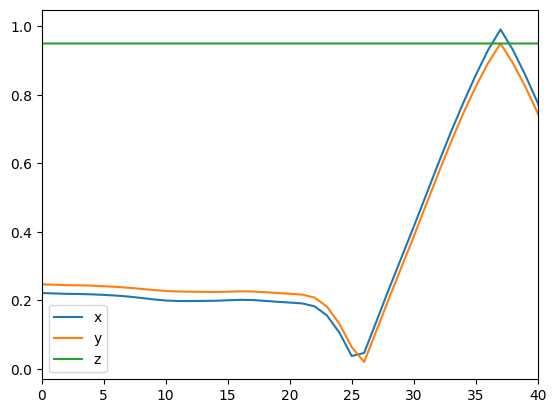

In [28]:
import matplotlib.pyplot as plt

# Your existing code
plt.plot(x)
plt.plot(y)
plt.plot(z)
plt.xlim(0, 40)

# Add legend
plt.legend(["x", "y", "z"])

# Display the plot
plt.show()

In [29]:
mask_top_full = onlypores(sitk.GetArrayFromImage(registered_volume_top))
moving_mask_image_full = sitk.GetImageFromArray(mask_top_full * 255)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000026F875552D0>>
Traceback (most recent call last):
  File "c:\Users\alberto.vicente\.conda\envs\VisionPyKernel\Lib\site-packages\ipykernel\ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
# EN VEZ DE HACER EL BSPLINE, SACAR EL VERDADERO ONLYPORES DE BOT Y TOP REGISTRADO Y HACER AFFINE CON ESO Y RANDOM 0.001 A VER QUE PASA.

# A VER SI CON ESTA SEMI ALINEACIÓN INICIAL TIENEN SUFICIENTE OVERLAPING

In [30]:
# Initialize the BSpline transformation
transform_domain_mesh_size = [20] * fixed_image_full.GetDimension()
initial_transform = sitk.BSplineTransformInitializer(
    fixed_image_full, transform_domain_mesh_size
)

# Set up the registration framework
registration_method = sitk.ImageRegistrationMethod()

# mask settings
registration_method.SetMetricFixedMask(fixed_mask_image_full)
registration_method.SetMetricMovingMask(moving_mask_image_full)

# Similarity metric settings
# registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricAsMeanSquares()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

# Interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings
registration_method.SetOptimizerAsRegularStepGradientDescent(
    learningRate=2.0,
    minStep=1e-4,
    numberOfIterations=100,
    relaxationFactor=0.5,
    gradientMagnitudeTolerance=1e-8,
    estimateLearningRate=registration_method.EachIteration,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
)
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: plot_values(registration_method)
)

0

In [31]:
# Run the registration
final_transform = registration_method.Execute(
    sitk.Cast(fixed_image_full, sitk.sitkFloat32),
    sitk.Cast(registered_volume_top, sitk.sitkFloat32),
)

Performing registration at new resolution...


KeyboardInterrupt: 

RuntimeError: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: D:\a\1\sitk\Wrapping\Python\sitkPyCommand.cxx:135:
sitk::ERROR: There was an error executing the Python Callable.

In [ ]:
# plot a slice from the mask and the original volume
import matplotlib.pyplot as plt

slice_index = 124
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sitk.GetArrayFromImage(fixed_image_full)[slice_index], cmap="gray")
plt.title("Original Bot")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(sitk.GetArrayFromImage(registered_volume_top2)[slice_index], cmap="gray")
plt.title("Mask Top")
plt.axis("off")
plt.show()

In [ ]:
# delete all files in folder
folder = Path(r"E:\temporal\volumenes\2+3+4+5\probando\3Dregistered")
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
    except Exception as e:
        print("Failed to delete %s. Reason: %s" % (file_path, e))

folder = Path(r"E:\temporal\volumenes\2+3+4+5\probando\3Dfixed")
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
    except Exception as e:
        print("Failed to delete %s. Reason: %s" % (file_path, e))

# save the concatenated volume
output_folder = Path(r"E:\temporal\volumenes\2+3+4+5\probando")
write_sequence(
    output_folder, "3Dregistered", sitk.GetArrayFromImage(resampled_moving_image)
)
write_sequence(output_folder, "3Dfixed", sitk.GetArrayFromImage(fixed_image))

Saving: 100%|██████████| 1003/1003 [00:02<00:00, 409.72it/s]


Saving complete.


Saving: 100%|██████████| 1003/1003 [00:01<00:00, 514.63it/s]

Saving complete.
